# PyTorch Model Deployment

## 0. Get setup

In [1]:
import torch
import torchvision

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


## 1. Getting Data

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment exepriment outline

### 3 questions:
1. what is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

## 3. Creating an EffNetB2 feature extractor

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:

def create_effnetb2_model(num_classes:int=3,
                          device=device):
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()

  effnetb2_model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

  for param in effnetb2_model.parameters():
    param.requires_grad = False

  effnetb2_model.classifier = nn.Sequential(
      nn.Dropout(p=.3, inplace=True),
      nn.Linear(in_features=1408,
                out_features=num_classes,
                bias=True)
  )

  return effnetb2_model.to(device), effnetb2_transforms

effnetb2, effnetb2_transforms = create_effnetb2_model(3,
                                                      device)
summary(model=effnetb2,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names'],
        input_size=(32, 3, 224, 224))


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 3.2 Create DataLoaders for EffNetB2

In [10]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=effnetb2_transforms,
                                                                               batch_size=32)

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eae08190eb0>,
 ['pizza', 'steak', 'sushi'])

### 3.3 Training effnetb2 feature extractor

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2.parameters(),
                             lr=0.001)

epochs = 10
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=epochs,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9923 | train_acc: 0.5062 | test_loss: 0.7746 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.7450 | train_acc: 0.8396 | test_loss: 0.6231 | test_acc: 0.9284
Epoch: 3 | train_loss: 0.5984 | train_acc: 0.8729 | test_loss: 0.5176 | test_acc: 0.9097
Epoch: 4 | train_loss: 0.4962 | train_acc: 0.9187 | test_loss: 0.4527 | test_acc: 0.9222
Epoch: 5 | train_loss: 0.4428 | train_acc: 0.8958 | test_loss: 0.3905 | test_acc: 0.9284
Epoch: 6 | train_loss: 0.4781 | train_acc: 0.8812 | test_loss: 0.3647 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4284 | train_acc: 0.8708 | test_loss: 0.3609 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3844 | train_acc: 0.8833 | test_loss: 0.3132 | test_acc: 0.9472
Epoch: 9 | train_loss: 0.3026 | train_acc: 0.9250 | test_loss: 0.3075 | test_acc: 0.9409
Epoch: 10 | train_loss: 0.2891 | train_acc: 0.9333 | test_loss: 0.2898 | test_acc: 0.9597


### 3.4 Inspecting Effnetb2 loss curves

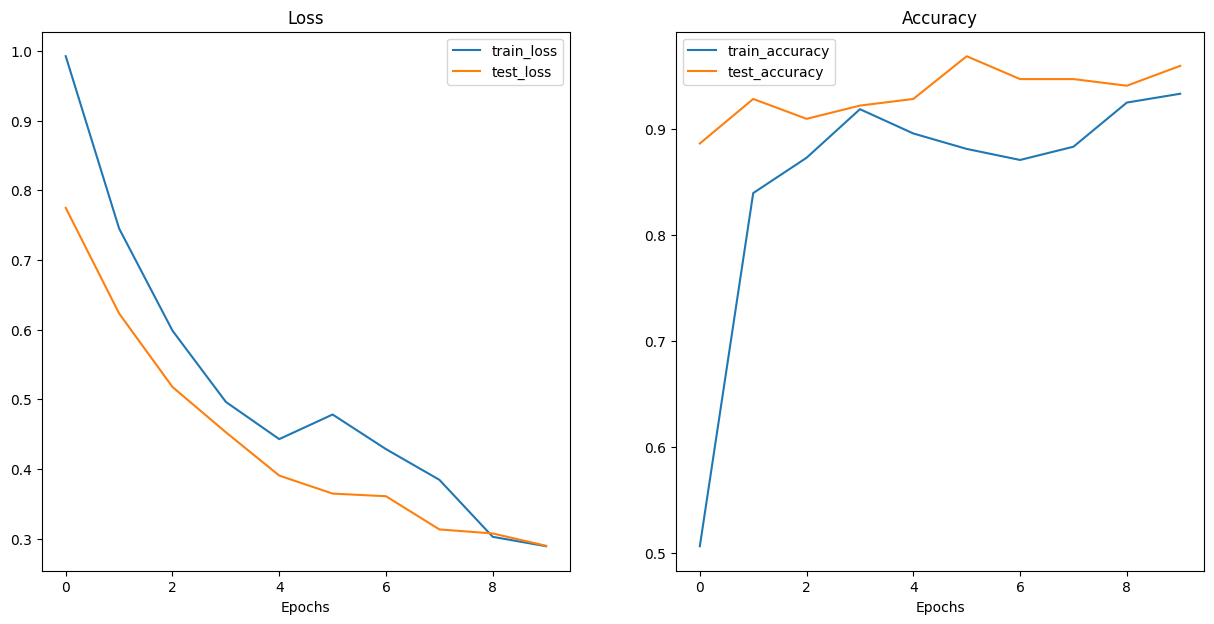

In [12]:
plot_loss_curves(effnetb2_results)

### 3.5 Saving effnetb2 feature extractor

In [13]:
from going_modular.going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrainet_effnetb2.pth")

[INFO] Saving model to: models/pretrainet_effnetb2.pth


### 3.6 Inspecting the size of our effnetb2 feature extractor

In [14]:
from pathlib import Path
pretrained_effnetb2_model_size = Path("models/pretrainet_effnetb2.pth").stat().st_size / (1024*1024)
print(f"Pretrained effnetb2 size: {pretrained_effnetb2_model_size:.2f} MB")

Pretrained effnetb2 size: 29.83 MB


### 3.7 Collecting EffNetB2 feature extractor states

In [15]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [16]:
effnetb2_stats = {"test_loss":effnetb2_results["test_loss"][-1],
                  "test_acc":effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28975509107112885,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.83111000061035}

## 4.Create a vit model

In [17]:
def create_vit_model(num_classes:int=3,
                     device=device):
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  vit_model = torchvision.models.vit_b_16(weights=vit_weights)
  vit_transform = vit_weights.transforms()

  for param in vit_model.parameters():
    param.requires_grad = False

  vit_model.heads = nn.Linear(in_features=768,
                              out_features=num_classes)

  return vit_model.to(device), vit_transform



In [18]:
vit, vit_transform = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 164MB/s] 


In [19]:
summary(model=vit,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 4.1 Create DataLoaders for ViT feature extrator

In [20]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        transform=vit_transform,
                                                                                        batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training the ViT feature extrator

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(),
                            lr=1e-3)

epochs = 10

vit_results = engine.train(model=vit,
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6416 | train_acc: 0.7583 | test_loss: 0.2396 | test_acc: 0.9563
Epoch: 2 | train_loss: 0.2155 | train_acc: 0.9479 | test_loss: 0.1294 | test_acc: 0.9750
Epoch: 3 | train_loss: 0.1573 | train_acc: 0.9646 | test_loss: 0.0965 | test_acc: 0.9938
Epoch: 4 | train_loss: 0.1283 | train_acc: 0.9667 | test_loss: 0.0798 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.1060 | train_acc: 0.9708 | test_loss: 0.0697 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.1357 | train_acc: 0.9771 | test_loss: 0.0649 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0798 | train_acc: 0.9771 | test_loss: 0.0653 | test_acc: 0.9938
Epoch: 8 | train_loss: 0.0701 | train_acc: 0.9833 | test_loss: 0.0633 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0613 | train_acc: 0.9854 | test_loss: 0.0607 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0549 | train_acc: 0.9938 | test_loss: 0.0583 | test_acc: 0.9875


### 4.3 Plot loss curves of ViT feature extrator

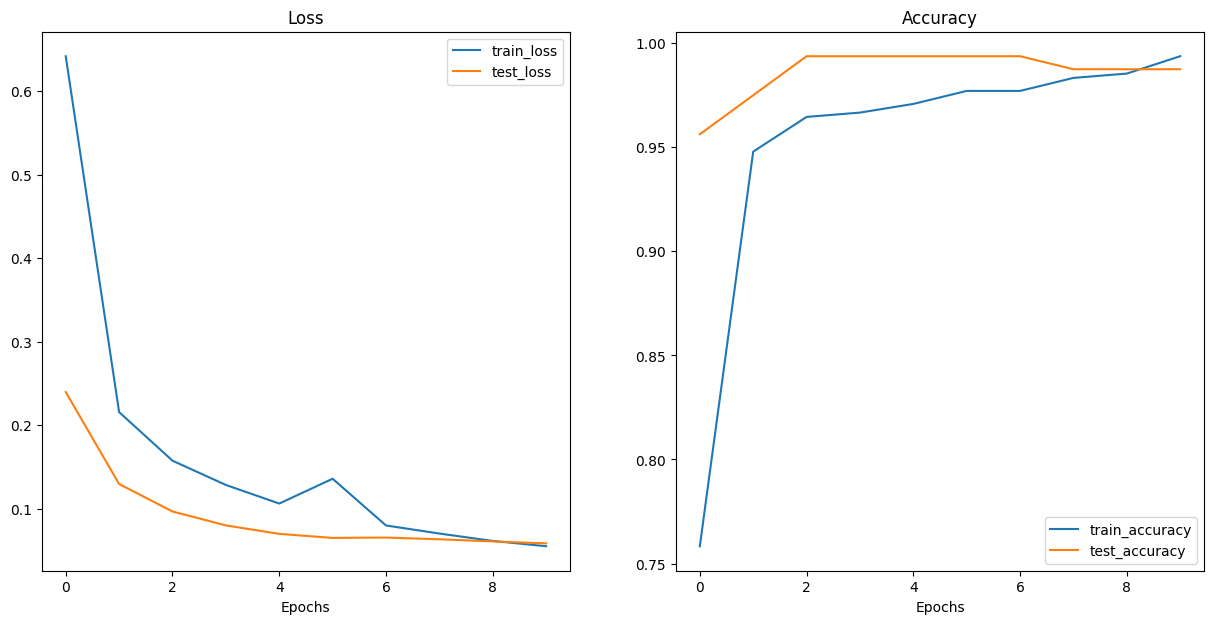

In [22]:
plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [23]:
from going_modular.going_modular import utils
utils.save_model(model=vit,
                target_dir="models",
                model_name="pretrained_vit.pth")

[INFO] Saving model to: models/pretrained_vit.pth


### 4.5 Checking the size of ViT feature extractor

In [24]:
from pathlib import Path

vit_model_size = Path("models/pretrained_vit.pth").stat().st_size / (1024*1024)
print(f"pretrained vit model size: {vit_model_size:.3f} MB")

pretrained vit model size: 327.363 MB


### 4.6 Collecting ViT feature extractor stats

In [25]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [26]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
            "test_acc": vit_results["test_acc"][-1],
            "number_of_parameters":vit_total_params,
            "model_size (MB)":vit_model_size}
vit_stats

{'test_loss': 0.05832819859497249,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3632869720459}

In [27]:
effnetb2_stats

{'test_loss': 0.28975509107112885,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.83111000061035}

## 5. Making predictions with our trained models and timing

In [28]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:10]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3497585.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/367422.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3138001.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/86782.jpg')]

### 5.1 Creating a function to make prediction across the test dataset

In [29]:
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

def pred_and_store(paths,
                   model,
                   transform,
                   class_names,
                   device=device):

    pred_list = []
    for path in tqdm(paths):
        pred_dict = {}
        class_name = path.parent.stem

        pred_dict["image_path"] = path
        pred_dict["class_name"] = class_name

        start_time = timer()
        img = Image.open(path)
        img_trans = transform(img).unsqueeze(0).to(device)

        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            y_logits = model(img_trans)
            pred_prob = torch.softmax(y_logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list

### 5.2 Making and timing predictions with EffNetB2

In [30]:
effnetb2_pred_dicts = pred_and_store(paths=test_data_paths,
                                   model=effnetb2,
                                   transform=effnetb2_transforms,
                                   class_names=class_names,
                                    device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
effnetb2_pred_dicts[:5]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9287,
  'pred_class': 'steak',
  'time_for_pred': 0.2105,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.5283,
  'pred_class': 'sushi',
  'time_for_pred': 0.0888,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9384,
  'pred_class': 'steak',
  'time_for_pred': 0.0839,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6181,
  'pred_class': 'steak',
  'time_for_pred': 0.0855,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9358,
  'pred_class': 'steak',
  'time_for_p

In [32]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_pred_df = pd.DataFrame(effnetb2_pred_dicts)
effnetb2_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9287,steak,0.2105,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5283,sushi,0.0888,False
2,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9384,steak,0.0839,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.6181,steak,0.0855,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9358,steak,0.0849,True


In [33]:
effnetb2_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [34]:
effnetb2_average_time_per_pred = round(effnetb2_pred_df.time_for_pred.mean(), 4)
effnetb2_average_time_per_pred

0.0857

In [35]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28975509107112885,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.83111000061035,
 'time_per_pred_cpu': 0.0857}

### 5.3 Making and timing predictions with ViT

In [36]:
vit_pred_dicts = pred_and_store(paths=test_data_paths,
                              model=vit,
                              transform=vit_transform,
                              class_names=class_names,
                               device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
vit_pred_dicts[:5]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9963,
  'pred_class': 'steak',
  'time_for_pred': 0.4928,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6009,
  'pred_class': 'steak',
  'time_for_pred': 0.2098,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9091,
  'pred_class': 'steak',
  'time_for_pred': 0.2136,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9508,
  'pred_class': 'steak',
  'time_for_pred': 0.2191,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9959,
  'pred_class': 'steak',
  'time_for_pr

In [38]:
vit_pred_df = pd.DataFrame(vit_pred_dicts)
vit_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9963,steak,0.4928,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.6009,steak,0.2098,True
2,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9091,steak,0.2136,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9508,steak,0.2191,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9959,steak,0.2592,True


In [39]:
vit_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [40]:
vit_average_time_per_pred = round(vit_pred_df.time_for_pred.mean(), 4)
vit_average_time_per_pred

0.2276

In [41]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05832819859497249,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3632869720459,
 'time_per_pred_cpu': 0.2276}

### 6. Comparing model results, prediction times and size

In [42]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["effnetb2", "vit"]
df["test_acc"] = round(df["test_acc"]*100, 2)
df.head()

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.289755,95.97,7705221,29.831110,0.0857,effnetb2
1,0.058328,98.75,85800963,327.363287,0.2276,vit


In [43]:
pd.DataFrame(data=(df.set_index("model").loc["vit"] / df.set_index("model").loc["effnetb2"]),
            columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.201302,1.028967,11.135432,10.973889,2.655776


### 6.1 Visualizing the speed vs performance tradeoff

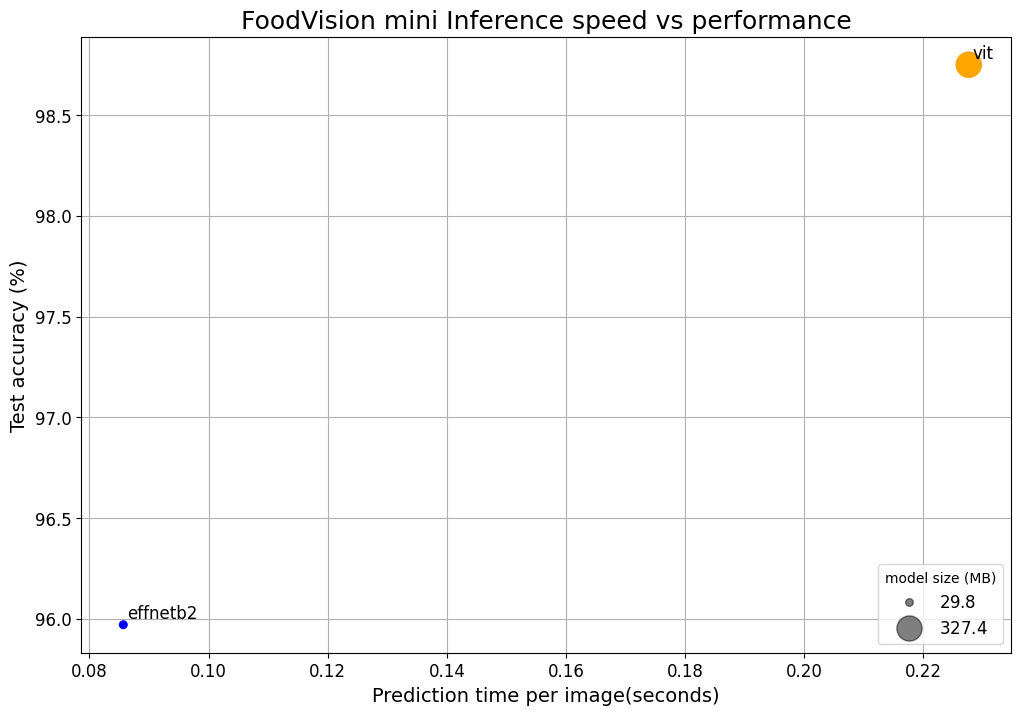

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")
ax.set_title("FoodVision mini Inference speed vs performance", fontsize=18)
ax.set_xlabel("Prediction time per image(seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
               xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
               size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legendd = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="model size (MB)",
                              fontsize=12)
plt.savefig("foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

In [45]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
distributed 2024.1.1 requires dask==2024.1.1, but you have dask 2024.5.2 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have urllib3 2.2.1 which is incompatible.
rapids-dask-dependency 24.4.1a0 requires dask==2024.1.1, but you have dask 2024.5.2 which is incompatible.
rapids-dask-dependency 24.4.1a0 requires dask-expr==0.4.0, but you have dask-expr 1.1.2 which is incompatible.
spacy 3.7.3 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, bu

### 7.1 Create a function to map our inputs and outputs

In [46]:
effnetb2 = effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [47]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    trans_img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        y_logits = effnetb2(trans_img)
        pred_probs = torch.softmax(y_logits, dim=1)

    pred_labels_and_probs = {class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 4)

    return pred_labels_and_probs, pred_time

In [48]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=1)[0]

random_image = Image.open(random_image_path)
pred_dict, pred_time = predict(random_image)
pred_dict, pred_time

({'pizza': 0.037424057722091675,
  'steak': 0.04173293709754944,
  'sushi': 0.9208430051803589},
 0.1026)

### 7.2 Creating a list of example images

In [49]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg']]

### 7.4 Building a Gradio Interface

In [50]:
import gradio as gr

title = "FoodVision Mini"
description = "An efficeintnetb2 feature extractor computer vision model to classify images as pizza, steak or sushi"

demo = gr.Interface(fn=predict,
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction time (s)")],
                   examples=example_list,
                   title=title,
                   description=description)

In [48]:
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()

Running on public URL: https://064e2d5c1ef84b19e6.gradio.live



This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

### 8.2 Deployed Gradio app structure

In [51]:
import shutil
from pathlib import Path


foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

### 8.4 Creating forlder of example images to use with our foovision mini demo

In [52]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]


for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [53]:
import os

example_list = [["examples/" + example] for example in  os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained Effnetb2 model to our FoodVision mini demo directory

In [54]:
import shutil

effnetb2_foodvision_model_path = "models/pretrainet_effnetb2.pth"

effnetb2_foodvision_model_dst = foodvision_mini_demo_path / effnetb2_foodvision_model_path.split("/")[1]
try:
    print(f"[INFO] attempting to mode{effnetb2_foodvision_model_path}")
    shutil.move(src=effnetb2_foodvision_model_path,
               dst=effnetb2_foodvision_model_dst)
    
    print("[INFO] Model move complete")
    
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_model_path}")

[INFO] attempting to modemodels/pretrainet_effnetb2.pth
[INFO] Model move complete


### 8.6 Turning off EffNetB2 model into a Python script (`model.py`)

In [72]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          device="cpu"):
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()

  effnetb2_model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

  for param in effnetb2_model.parameters():
    param.requires_grad = False

  effnetb2_model.classifier = nn.Sequential(
      nn.Dropout(p=.3, inplace=True),
      nn.Linear(in_features=1408,
                out_features=num_classes,
                bias=True)
  )

  return effnetb2_model.to(device), effnetb2_transforms


Overwriting demos/foodvision_mini/model.py


In [56]:
class_names

['pizza', 'steak', 'sushi']

### 8.7 Turning our FoodVision Mini Gradio app into a Python scrip (`app.py`)

In [81]:
%%writefile demos/foodvision_mini/app.py

import torch
import gradio as gr
from typing import Tuple, Dict
from model import create_effnetb2_model
from timeit import default_timer as timer
import os

class_names = ['pizza', 'steak', 'sushi']

effnetb2, effnetb2_transforms = create_effnetb2_model(len(class_names),"cpu")
effnetb2.load_state_dict(torch.load(f="pretrainet_effnetb2.pth",
                                   map_location=torch.device("cpu")))

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    trans_img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        y_logits = effnetb2(trans_img)
        pred_probs = torch.softmax(y_logits, dim=1)

    pred_labels_and_probs = {class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 4)

    return pred_labels_and_probs, pred_time


example_list = [["examples/" + example] for example in  os.listdir("examples")]
title = "FoodVision Mini"
description = "An efficeintnetb2 feature extractor computer vision model to classify images as pizza, steak or sushi"

demo = gr.Interface(fn=predict,
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction time (s)")],
                   examples=example_list,
                   title=title,
                   description=description)

demo.launch()

Overwriting demos/foodvision_mini/app.py


### 8.8 Create `requirements.txt`

In [64]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.1.2
torchvision==0.16.2
gradio==4.36.1

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app HuggingFace Spaces

In [66]:
!ls demos/foodvision_mini

app.py	examples  model.py  pretrainet_effnetb2.pth  requirements.txt


In [67]:
!pip install huggingface_hub

In [71]:
!cd demos/foodvision_mini/ && zip -r ../foodvision_min.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

updating: app.py (deflated 55%)
updating: examples/ (stored 0%)
updating: examples/592799.jpg (deflated 1%)
updating: examples/2582289.jpg (deflated 17%)
updating: examples/3622237.jpg (deflated 0%)
updating: model.py (deflated 55%)
updating: pretrainet_effnetb2.pth (deflated 8%)
updating: requirements.txt (deflated 4%)


## 10. Creating FoodVision Big

### 10.1 Creating a model for FoodVision Big + transforms

In [75]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101,
                                                             device=device)

summary(model=effnetb2_food101,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names'],
        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [80]:
food_101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

### 10.2 getting data for FoodVision Bi